In [1]:
import torch 


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
from helper_functions import download_data
# Download pizza, steak, sushi images from GitHub 
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination= "pizza_steak_sushi")
image_path 

/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images 
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
from torchvision import transforms
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually 
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms : {manual_transforms}")

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
from going_modular import data_setup 
# Set the batch size 
BATCH_SIZE = 32 

# Create data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir = test_dir,
    transform= manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f6148a56580>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images 
image_batch , image_label = next(iter(train_dataloader))

# Get a single image from the batch 
image, label = image_batch[0], image_label[0]

# View the batch shapes 
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

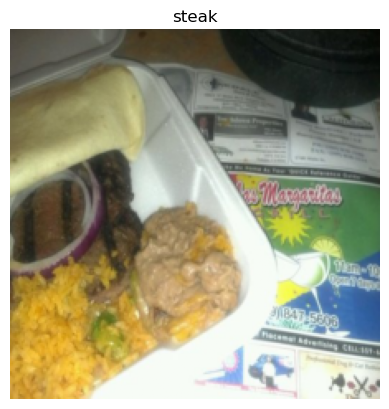

In [8]:
import matplotlib.pyplot as plt 
# Plot image with matplotlib 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [9]:
# Create example values 
height = 224 
width = 224
color_channels = 3
patch_size = 16
number_of_patches  = int((height * width) / patch_size**2)
# Calculate N 
print(f"Number of patches (N) wih image height (H={height}), width (W={width}) and patch size (P={patch_size})")


Number of patches (N) wih image height (H=224), width (W=224) and patch size (P=16)


In [10]:
# Input shape (this is the size of a image)
embedding_layer_input_shape = (height,width,color_channels)

# Output shape 
embedding_layer_output_shape = (number_of_patches,patch_size**2*color_channels)

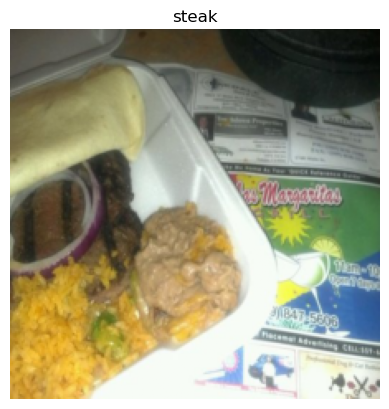

In [11]:
# View single image 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

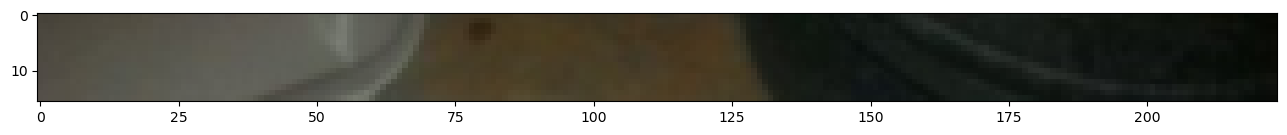

In [12]:
# Change image shape to be compaible with matplotlib  (color_channels,height,width) -> (height,width, color_channels)
image_permuted = image.permute(1,2,0)

# Index to plot the top row of patched pixels 
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

Number of patches per row: 14.0
 Patch size: 16 pixels x 16 pixels


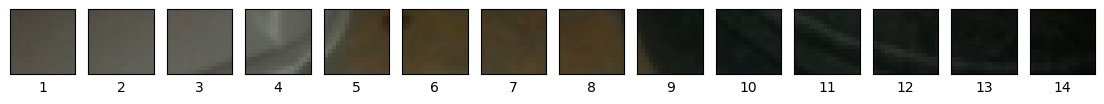

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible 
img_size = 224 
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row 
for i,patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
 Number of patches per column : 14.0
 Total patches: 196.0
 Patch size: 16 pixels x 16 pixels


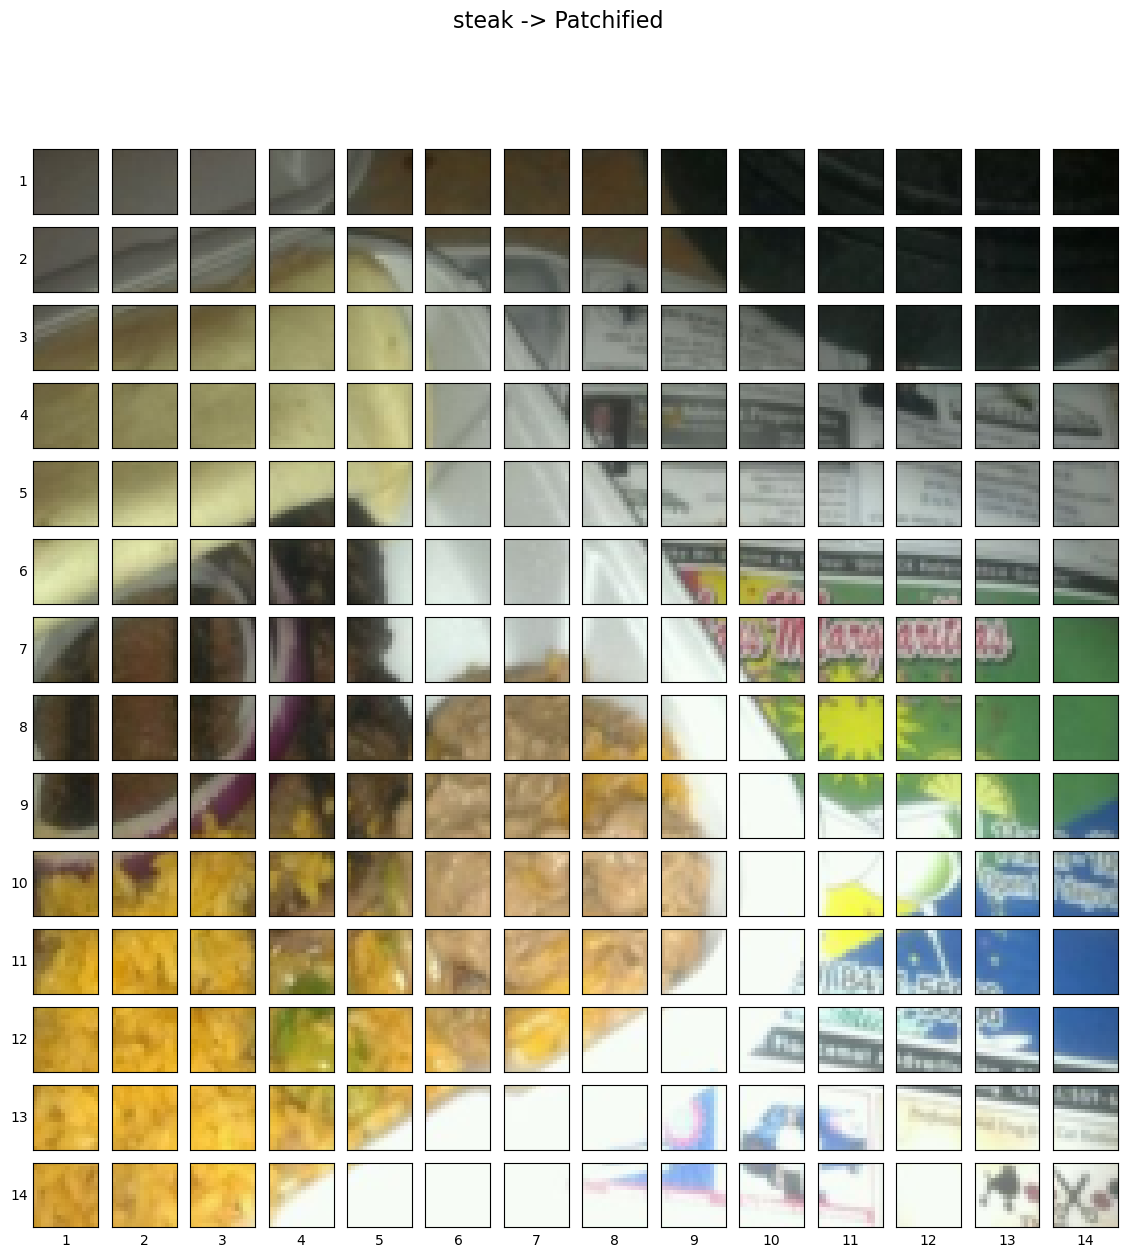

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible 
img_size = 224 
patch_size = 16 
num_patches = img_size / patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\n Number of patches per column : {num_patches}\n Total patches: {num_patches*num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image 
for i, patch_height in enumerate(range(0,img_size,patch_size)):
    for j, patch_width in enumerate(range(0,img_size,patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

# Set a super title 
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [15]:
from torch import nn 

# Set the patch size 
patch_size = 16 

# Create the Conv2d layer with hyperparameters from the ViT paper 
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)


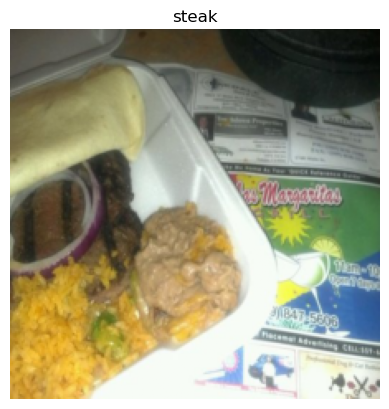

In [16]:
# View single image 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
# Pass the image throught the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes : [295, 672, 140, 417, 723]


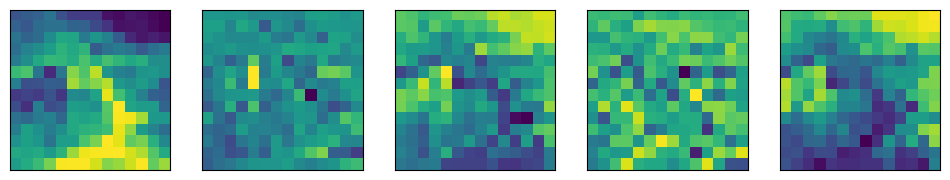

In [18]:
# Plot random 5 convolutional feature maps 
import random 
random_indexes = random.sample(range(0,758),k=5)
print(f"Showing random convolutional feature maps from indexes : {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

# Plot random image feature maps 
for i , idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:,idx,:,:]

# index on the output tnesor of the convolutional layer 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



In [19]:
# Get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad
single_feature_map.shape

torch.Size([1, 14, 14])

In [20]:
# Create flatten layer 
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)


Original image shape : torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


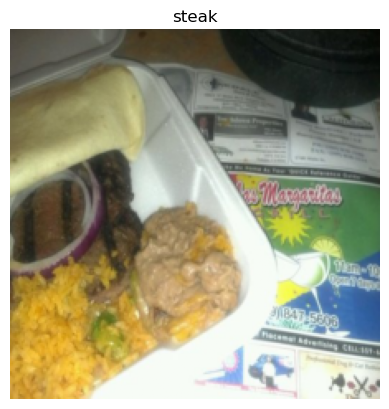

In [21]:
# 1. View single image 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape : {image.shape}")

# 2. Turn image into feature maps 
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps 
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [22]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape : {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape : torch.Size([1, 196, 768])


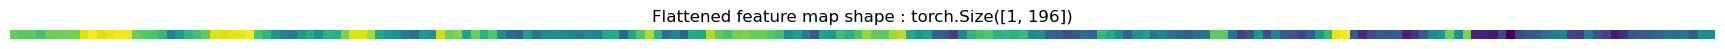

In [23]:
# Get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

# Plot the flattened feature map visually 
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape : {single_flattened_feature_map.shape}")
plt.axis(False);

In [24]:
# 1. Create a class which subclasses nn.Module 
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable embedding vector. 

    Args:
    in_channels (int) : Number of color channels for the input images . Defaults to 3. 
    patch_size (int) : Size of patches to convert input image into. Defaults to 16. 
    embedding_dim (int) : Size of embedding to turn image into. Defaults to 768. 
    """

    # 2. Initialize the class with appropriate variables 
    def __init__(self,
                 in_channels : int=3,
                 patch_size : int=16,
                 embedding_dim : int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches 
        self.patcher = nn.Conv2d(in_channels= in_channels,
                                 out_channels= embedding_dim,
                                 kernel_size= patch_size,
                                 stride= patch_size,
                                 padding= 0)
        
        # 4. Create a layer to flatten the patch feature maps into a single dimension 
        self.flatten = nn.Flatten(start_dim= 2,
                                  end_dim= 3)
        
        # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape 
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size : {patch_size}"

        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0,2,1)

In [25]:
from helper_functions import set_seeds
set_seeds()

# Create an instance of patch embedding layer 
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through 
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [26]:
from torchinfo import summary
# Create random input sizes 
random_input_image = (1,3,224,224)
random_input_image_error = (1,3,250,250)

# Get a summary of the input and outputs of PatchEmbedding 
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names = ["input_size", "output_size","num_params","trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [27]:
# Get the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter  that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)



In [28]:
# Add the class token embedding to the front of te patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)


In [29]:
# Calculate N (number of patches) 
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension 
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding 
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                             requires_grad=True)
print(position_embedding[:,:10,:10])
print(position_embedding.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [30]:
# Add the position embedding to the patch and class token embedding 
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding 
print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.6620,  1.0879,  0.8765,  ...,  1.2432,  0.8639,  1.1097],
         [ 0.6211,  1.1010,  0.8599,  ...,  1.2767,  0.8481,  1.1291],
         ...,
         [-0.0173,  1.2781,  0.7104,  ...,  1.7767,  0.5421,  1.3573],
         [ 0.4201,  1.2971,  0.7694,  ...,  1.7185,  0.5097,  1.2726],
         [ 0.1747,  1.1485,  0.8206,  ...,  1.6804,  0.4908,  1.2624]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


In [31]:
set_seeds()

# 1. Set patch size 
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions 
print(f"Image tensor shape: {image.shape}")
height,width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension 
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer 
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image throught patch embedding layer 
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding 
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)

print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding 
patch_embedding_class_token = torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding 
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)

# 9. Add position embedding to patch embedding with class token 
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [32]:
# 1. Create a class that inherits from nn.Module 
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1 
    def __init__(self,
                 embedding_dim : int=768,
                 num_heads : int=12,
                 attn_dropout : float=0):
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer 
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads= num_heads,
                                                    dropout= attn_dropout,
                                                    batch_first= True)
    
    # 5. Create a forward() method to pass the data throught the layers 
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights= False)
        return attn_output

In [33]:
#  Create an instance of MSABlock 
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim= 768,
                                                             num_heads= 12)

# Pass patch and position image embedding throught MSABlock 
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block : {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block : torch.Size([1, 197, 768])


In [34]:
# 1. Create a class that inherits from nn.Module 
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3 
    def __init__(self, 
                 embedding_dim : int=768,
                 mlp_size : int=3072,
                 dropout : float=0.1):
        super().__init__()
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features = mlp_size,
                      out_features= embedding_dim),
            nn.Dropout(p=dropout),       
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x 
    

In [35]:
# Create an instance of MLPBlock 
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size= 3072,
                     dropout=0.1)

# Pass output of MSABlock through MLPBlock 
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MSA block : {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MSA block : torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [36]:
# 1. Create a class that inherits from nn.Module 
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3 
    def __init__(self, 
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size : int=3072,
                 mlp_dropout : float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        # 3. Create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim= embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block 
        self.mlp_block = MLPBlock(embedding_dim= embedding_dim,
                                  mlp_size= mlp_size,
                                  dropout= mlp_dropout)
        
    
    def forward(self, x):
        
        # 6. Create residual connection for MSA block 
        x = self.msa_block(x) + x 

        # 7. Create residual connection for MLP block 
        x = self.mlp_block(x) + x
        
        return x 

In [37]:
from torchinfo import summary
# Create an instance of TransformerEncoderBlock 
transfromer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer 
summary(model = transfromer_encoder_block,
        input_size=(1,197,768),
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [38]:
# Create the same as above with torch.nn.TransformerEncoderlayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [39]:
summary(model = torch_transformer_encoder_layer,
        input_size=(1,19,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 19, 768]         [1, 19, 768]         7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.06

In [40]:
# 1. Create a ViT class that inherits from nn.Module 
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3 
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim: int=768,
                 mlp_size:int=3072,
                 num_heads: int=12,
                 attn_dropout:float=0,
                 mlp_dropout: float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        # 3. Make the image size is divisible by the patch size 
        assert img_size % patch_size ==0, f"Image size must be divisible by patch size, image size: {img_size}, patch_size : {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

        # 6. Create learnable position embedding 
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad=True)

        # 7. Create embedding dropout value 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer 
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )
        
        # 10. Create classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    
    def forward(self, x):

        # 12. Get batch size 
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size,-1,-1)

        # 14. Create patch embedding(equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding 
        x = torch.cat((class_token,x),dim=1)

        # 16. Add position embedding to patch embedding 
        x = self.position_embedding + x 

        # 17. Run embedding dropout

        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding throught transformer encoder layers 
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier 
        x = self.classifier(x[:,0])
        
        return x 

In [41]:
# Example of creating the class embedding and expanding over a batch dimension 
batch_size = 32 
class_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size,-1,-1)
print(f"Shape of class token embedding single : {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single : torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [42]:
set_seeds()

# Create a random tensor with same shape as a single image 
random_image_tensor = torch.randn(1,3,224,224)

# Create an instance of ViT with the number of classes we're working with(pizza,steak,sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance 
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [43]:
from going_modular import engine 

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# # Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary 
# results = engine.train(model=vit,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=5,
#                        device=device)

# Kernel dead so i can't run this codes!!!

/home/rudgh1999/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Getting a pretrained ViT model and creating a feature extractor

In [44]:
# The following requires torch v0.12+ and torchvision v0.13+ 
import torch 
import torchvision 
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.15.2a0


In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
# 1. Get pretrained weights for ViT-base 
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False 

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/rudgh1999/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:34<00:00, 10.0MB/s] 


In [48]:
summary(model = pretrained_vit,
        input_size=(32,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [49]:
from helper_functions import download_data 

# Download pizza, steak, sushi images from GitHub 
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination= "pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [50]:
# Setup train and test directory paths 
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [51]:
# Get automatic transforms from pretrained ViT weights 
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [52]:
from going_modular import data_setup
# Setup dataloaders 
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [53]:
from going_modular import engine 

# Create optimizer and loss function 
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model 
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:47<07:05, 47.31s/it]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665


 20%|██        | 2/10 [01:34<06:19, 47.49s/it]

Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977


 30%|███       | 3/10 [02:22<05:33, 47.65s/it]

Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081


 40%|████      | 4/10 [03:10<04:45, 47.52s/it]

Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081


 50%|█████     | 5/10 [03:58<03:58, 47.72s/it]

Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977


 60%|██████    | 6/10 [04:45<03:10, 47.68s/it]

Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280


 70%|███████   | 7/10 [05:32<02:22, 47.51s/it]

Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883


 80%|████████  | 8/10 [06:19<01:34, 47.19s/it]

Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778


 90%|█████████ | 9/10 [07:06<00:47, 47.14s/it]

Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384


100%|██████████| 10/10 [07:53<00:00, 47.32s/it]

Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


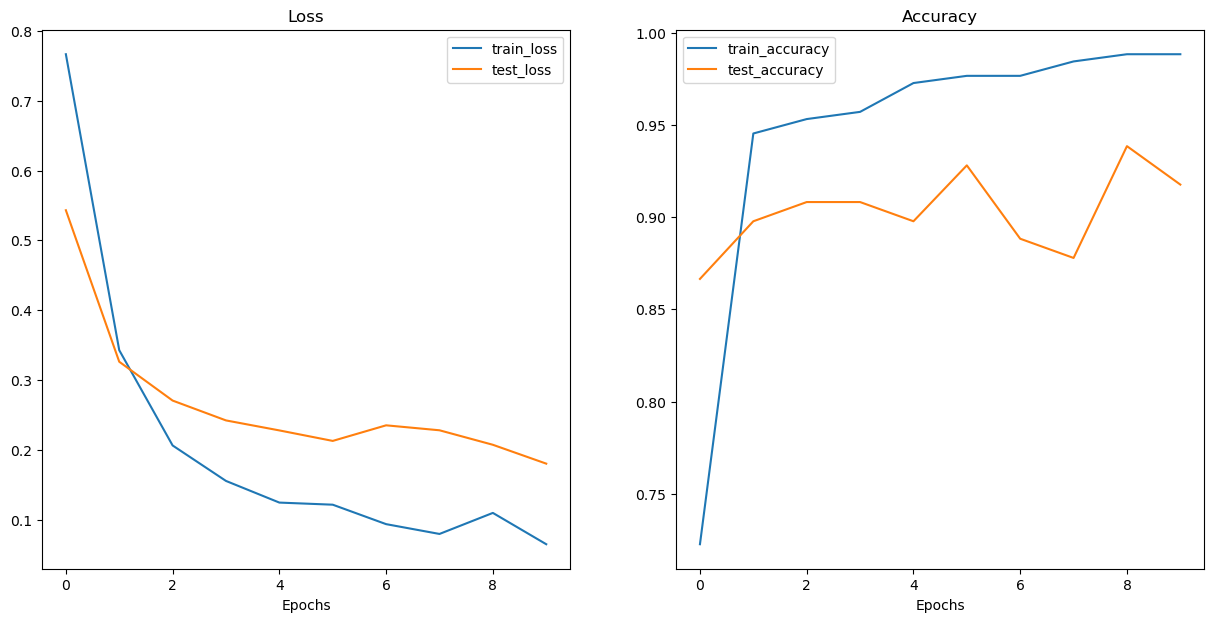

In [54]:
# Plot the loss curves 
from helper_functions import plot_loss_curves 

plot_loss_curves(pretrained_vit_results)

In [57]:
# Save the model 
from going_modular import utils 

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [60]:
from pathlib import Path 

# Get the model size in bytes then convert to megabytes 
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size : {pretrained_vit_model_size}MB")


Pretrained ViT feature extractor model size : 327MB


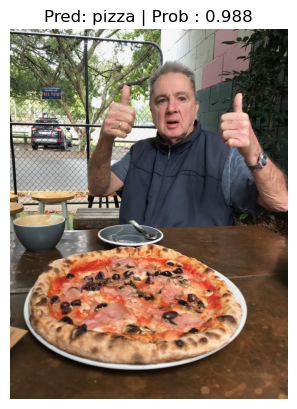

In [61]:
import requests 

# Import function to make predictions on images and plot them 
from going_modular.predictions import pred_and_plot_image 

# Setup custom image path 
custom_image_path = image_path / "04-piza-dad.jpeg"

# Download the image if it doesn't already exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path} ...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image 
pred_and_plot_image(model = pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)